In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

from keras.layers import Input, Conv2D, MaxPooling2D, ReLU, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, Activation
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

np.random.seed(1)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
folder = '../input/anime-faces/data/data'
l = os.listdir(folder)

train_data = []

for i in l[:20000]:
    try:
        # 로드
        src = cv2.imread(folder+"/"+i, cv2.IMREAD_COLOR)
        st = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
        train_data.append(st)
    except:
        print(i)
        continue

train_data = np.array(train_data)

# train_data2 = (train_data.astype(np.float32) - 127.5)/127.5
train_data = train_data.astype(np.float32) / 255
print(train_data.shape)

(20000, 64, 64, 3)


In [3]:
class GENs():
    
    def __init__(self):
        
        self.random_dim = 100
        
        self.generator = Sequential()
        self.discriminator = Sequential()
        
        # 우리의 GAN 네트워크를 만듭니다.
        adam = self.get_optimizer()
        self.set_generator(adam)
        self.set_discriminator(adam)
        
        self.discriminator.trainable = False
        
        # placeholder
        gan_input = Input(shape=(self.random_dim,))
        
        # 생성
        X = self.generator(gan_input)
        
        # 검출
        gan_output = self.discriminator(X)
        
        # 최종 모델 생성
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=adam)
    
    def train(self, epochs=1, batch_size=128):
        
        batch_count = train_data.shape[0] // batch_size
        
        for e in range(1, epochs+1):
            if e == 1 or e % 10 == 0:
                print('-'*15, 'Epoch %d' % e, '-'*15)
            for _ in tqdm(range(batch_count)):
                # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
                noise = np.random.normal(0, 1, size=[batch_size, self.random_dim])

                image_batch = train_data[np.random.randint(0, train_data.shape[0], size=batch_size)]

                # 이미지 생성
                generated_images = self.generator.predict(noise)
                X = np.concatenate([image_batch, generated_images])

                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9

                # Discriminator를 학습시킵니다.
                self.discriminator.trainable = True
                self.discriminator.train_on_batch(X, y_dis)

                # Generator를 학습시킵니다.
                noise = np.random.normal(0, 1, size=[batch_size, self.random_dim])
                y_gen = np.ones(batch_size)
                self.discriminator.trainable = False
                self.gan.train_on_batch(noise, y_gen)
            if e == 1 or e % 100 == 0:
                self.plot_generated_images(e)
    
    def get_optimizer(self):
        return Adam(lr=0.0002, beta_1=0.5)
    
    # Generator
    def set_generator(self, optimizer):
        self.generator.add(Dense(4*4*64*4, input_dim=self.random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        self.generator.add(BatchNormalization(momentum=0.9))
        self.generator.add(LeakyReLU(0.2))
        self.generator.add(Reshape((4,4,64*4)))
        self.generator.add(Dropout(0.3))
        
        # 8 * 8
        self.generator.add(UpSampling2D())
        self.generator.add(Conv2DTranspose(64*2, 5, padding='same'))
        self.generator.add(BatchNormalization(momentum=0.9))
        self.generator.add(LeakyReLU(0.2))

        # 16 * 16
        self.generator.add(UpSampling2D())
        self.generator.add(Conv2DTranspose(64, 5, padding='same'))
        self.generator.add(BatchNormalization(momentum=0.9))
        self.generator.add(LeakyReLU(0.2))
        
        
        self.generator.add(UpSampling2D())
        self.generator.add(Conv2DTranspose(32, 5, padding='same'))
        self.generator.add(BatchNormalization(momentum=0.9))
        self.generator.add(LeakyReLU(0.2))
        
        self.generator.add(UpSampling2D())
        self.generator.add(Conv2DTranspose(64, 5, padding='same'))
        self.generator.add(BatchNormalization(momentum=0.9))
        self.generator.add(LeakyReLU(0.2))
        
        self.generator.add(Conv2DTranspose(3, 5, padding='same'))
        self.generator.add(Activation("tanh"))
        
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    # Discriminator 만들기
    def set_discriminator(self, optimizer):
#         self.discriminator.add(Dense(4096, input_dim=64*64, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        self.discriminator.add(Conv2D(16, kernel_size=3, input_shape=(64,64,3), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(MaxPooling2D(pool_size=(2, 2)))
        self.discriminator.add(Dropout(0.3))

        self.discriminator.add(Conv2D(32, kernel_size=3))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(MaxPooling2D(pool_size=(2, 2)))
        self.discriminator.add(Dropout(0.3))
        
        self.discriminator.add(Conv2D(64, kernel_size=3))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(MaxPooling2D(pool_size=(2, 2)))
        self.discriminator.add(Dropout(0.3))
        self.discriminator.add(Flatten())
            
        self.discriminator.add(Dense(128))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(Dropout(0.3))

        self.discriminator.add(Dense(64))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(Dropout(0.3))

        self.discriminator.add(Dense(1, activation='sigmoid'))
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # train 중 image 검사
    def plot_generated_images(self, epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
        noise = np.random.normal(0, 1, size=[examples, self.random_dim])
        generated_images = self.generator.predict(noise)
        generated_images = generated_images.reshape(examples, 64, 64, 3)

        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
     
    ################################################
    #  사용
    ################################################
    
    # noise 생성
    def create_noise(self, examples=100):
        noise = np.random.normal(0, 1, size=[examples, self.random_dim])
        return noise
    
    # predict 값 반환
    def generater_predict(self, noise):
        generated_images = self.generator.predict(noise)
        generated_images = generated_images.reshape(noise.shape[0], 64, 64, 3)
        return generated_images
    
    def output_model(self, pre, name):
        
        model_json = self.generator.to_json()
        with open(pre+"generator_"+name+".json", "w") as json_file : 
            json_file.write(model_json)
        
        model_json = self.discriminator.to_json()
        with open(pre+"discriminator_"+name+".json", "w") as json_file : 
            json_file.write(model_json)
        
        model_json = self.gan.to_json()
        with open(pre+"gan_"+name+".json", "w") as json_file : 
            json_file.write(model_json)
            
        self.generator.save_weights(pre+"generator_weight_"+name+".h5")
        self.discriminator.save_weights(pre+"discriminator_weight_"+name+".h5")
        self.gan.save_weights(pre+"gan_weight_"+name+".h5")
        

In [4]:
gans = GENs()
gans.train(epochs=900, batch_size=128)

  0%|          | 0/156 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 1/156 [00:00<00:17,  8.76it/s]

--------------- Epoch 10 ---------------


  1%|          | 1/156 [00:00<00:17,  8.70it/s]

--------------- Epoch 20 ---------------


  1%|          | 1/156 [00:00<00:17,  8.64it/s]

--------------- Epoch 30 ---------------


  1%|          | 1/156 [00:00<00:18,  8.17it/s]

--------------- Epoch 40 ---------------


 62%|██████▏   | 96/156 [00:11<00:07,  8.52it/s]

In [5]:
gans.output_model("","")

In [6]:
from matplotlib import animation, rc
from IPython.display import HTML

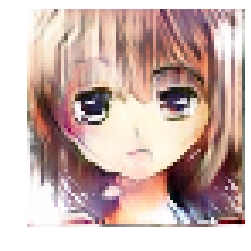

In [7]:
fig = plt.figure()
plt.axis('off')
noise = np.zeros((1,100))
p = gans.generater_predict(noise)

r = p.reshape((1,64,64,3))[0]

im=plt.imshow(r, interpolation='nearest', cmap='gray')

def init():
    im.set_data(r)
    return [im]

a = gans.create_noise(1)
b = np.zeros((1,100))  
  
def animate(i):
    global a, b
    x = np.linspace(0, np.pi, 100)
    if i % 50 == 0:
        a = gans.create_noise(1)
    else:
        b = a * np.sin(2 * np.pi * (x - 0.02 * i))*np.cos(1 * np.pi * (x - 0.01 * i))*0.7+0.2
    
    p = gans.generater_predict(b)
    r = p.reshape((1,64,64,3))[0]
    
    im.set_array(r)
    return [im]
  
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=1000, interval=100, blit=True)
anim.save('animation.gif', fps=30, extra_args=['-vcodec', 'libx264'])

# plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
# HTML(anim.to_html5_video())

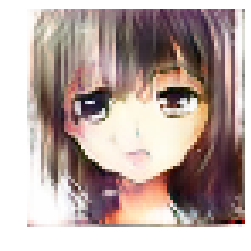

In [8]:
# noise = np.zeros((1,100))
noise = gans.create_noise(1)
p = gans.generater_predict(noise)
r = p.reshape((1,64,64,3))[0]

plt.imshow(r)
plt.axis('off')
plt.show()